<center>
    <img src="https://github.com/sinaaghaee/ProcessMiningProject-CustomerBehaviorAnalysis/blob/main/Images/Sharif_Logo.png?raw=true" width="250"   />
</center>

# Time Series Analysis Project - SFO Passengers

 ## Course Info:
 
 **Student/Analyst:**  Sina Aghaee <br>
 **Course:** Time Series Analysis and Forcasting 1399-1400 <br>
 **Institution:** Sharif University of Technology, Department of Industrial Engineering <br>
 **Instructor:**  Dr. Majid Khedmati 


In this notebook, I will do a Time Series analysis and prediction of the monthly passengers landing at San Francisco International Airport.

We will use use **R language** and **SFO passenger dataset** for our analysis. 

The sfo_passengers dataset provides monthly statistics about the air traffic passengers in San Francisco International Airport between July 2005 and September 2020. That includes monthly information on the total number of passengers arriving or departing from SFO by airline operator, geographic type (domestic and international), and region (e.g., US, Europe, Mexico, Asia).

In [47]:
# Turning off the warnings
options(warn=-1)

# Importing required libraries
library(sfo)
library(dplyr)
library(plotly)
library(TSstudio)
library(forecast)
library(uroot)
library(tseries)
library(lmtest)
library(astsa)
library(TSA)

# 1. Loading the SFO-Passengers Data, Preprocessing and some descriptive analysis

In [3]:
# loading the data
data("sfo_passengers")
str(sfo_passengers)


'data.frame':	22869 obs. of  12 variables:
 $ activity_period            : int  202012 202012 202012 202012 202012 202012 202012 202012 202012 202012 ...
 $ operating_airline          : chr  "United Airlines" "United Airlines" "United Airlines" "United Airlines" ...
 $ operating_airline_iata_code: chr  "UA" "UA" "UA" "UA" ...
 $ published_airline          : chr  "United Airlines" "United Airlines" "United Airlines" "United Airlines" ...
 $ published_airline_iata_code: chr  "UA" "UA" "UA" "UA" ...
 $ geo_summary                : chr  "Domestic" "Domestic" "International" "International" ...
 $ geo_region                 : chr  "US" "US" "Asia" "Asia" ...
 $ activity_type_code         : chr  "Enplaned" "Thru / Transit" "Deplaned" "Enplaned" ...
 $ price_category_code        : chr  "Other" "Other" "Other" "Other" ...
 $ terminal                   : chr  "Terminal 3" "Terminal 3" "International" "International" ...
 $ boarding_area              : chr  "F" "F" "G" "G" ...
 $ passenger_count

In [4]:
## Transforming the activity_period column in dataset into a Date format
df <- sfo_passengers %>% mutate(Date = as.Date(paste(substr(sfo_passengers$activity_period, 1,4), 
                                                     substr(sfo_passengers$activity_period, 5,6), 
                                                     "01", sep ="/"))) 

In [5]:
## Transforming the dataset into a time series format by grouping the passenger by the date variable
df <- df %>% group_by(Date) %>%  summarise(passengers = sum(passenger_count), .groups = "drop")
head(df) 
str(df)
df$passengers <- as.numeric(df$passengers)

Date,passengers
<date>,<int>
2005-07-01,3225769
2005-08-01,3195866
2005-09-01,2740553
2005-10-01,2770715
2005-11-01,2617333
2005-12-01,2671797


tibble[,2] [186 x 2] (S3: tbl_df/tbl/data.frame)
 $ Date      : Date[1:186], format: "2005-07-01" "2005-08-01" ...
 $ passengers: int [1:186] 3225769 3195866 2740553 2770715 2617333 2671797 2448889 2223024 2708778 2773293 ...


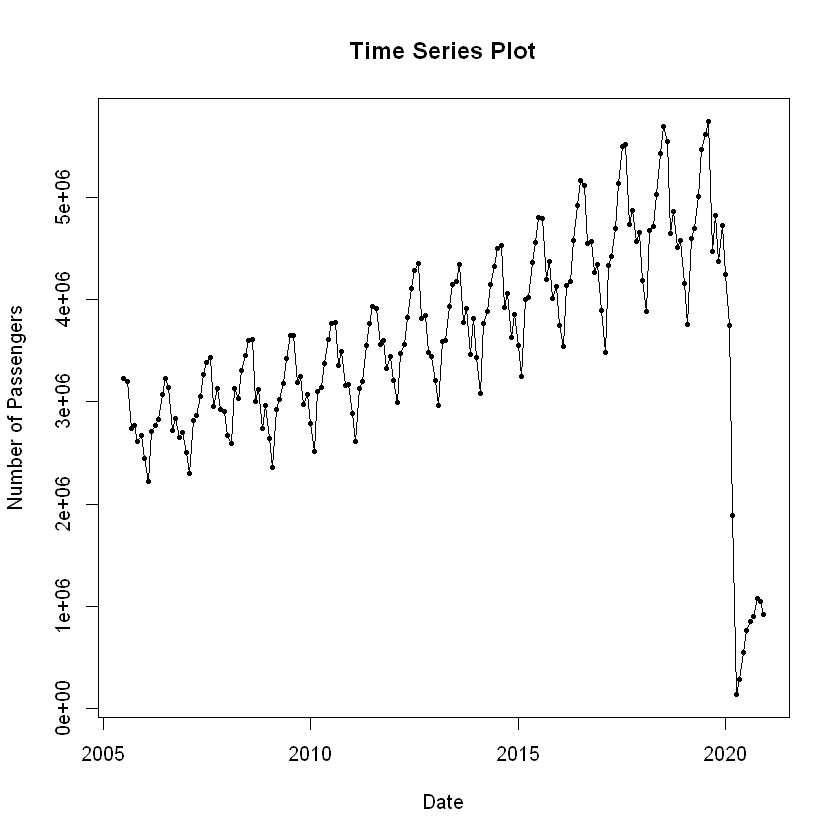

In [75]:
## Time Series plot for the whole Data
plot(df, type = "l", xlab = "Date", ylab = "Number of Passengers", main = "Time Series Plot")
points(df, pch = 16, cex = 0.5)

In [54]:
## pre_Covid data
df_precovid <- subset(df, Date<'2020-01-01')

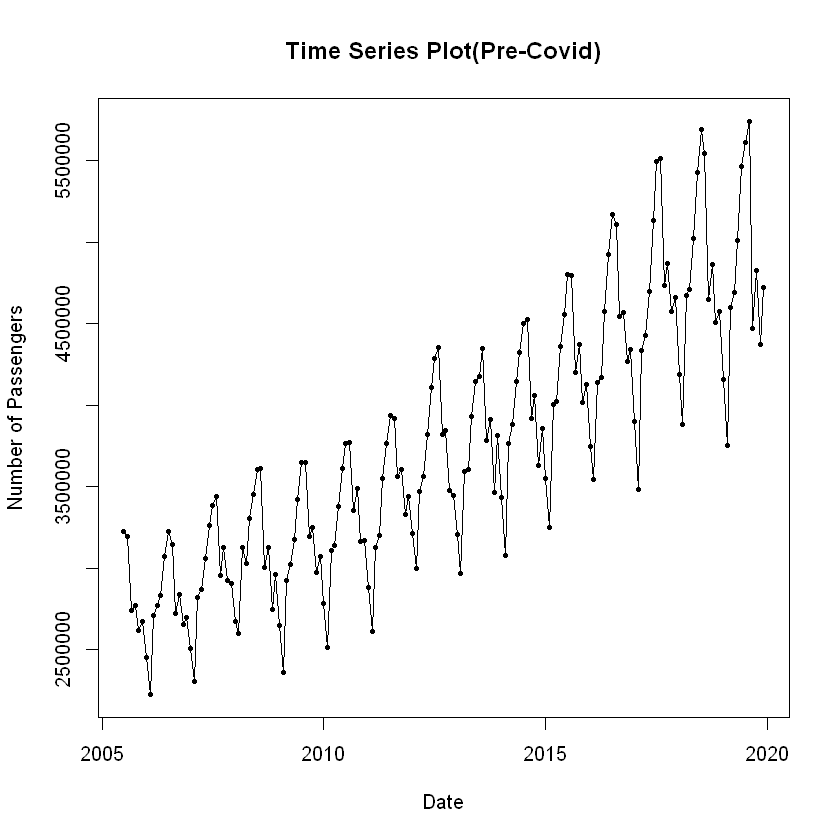

In [55]:
## Plotting the pre-Covid Data
plot(df_precovid, type = "l", xlab = "Date", ylab = "Number of Passengers", main = "Time Series Plot(Pre-Covid)")
points(df_precovid, pch = 16, cex = 0.5)


In [56]:
## Transforming passengers Time Series into Time Series object
passengers <- ts(df_precovid$passengers, start = c(2005, 7), frequency = 12)

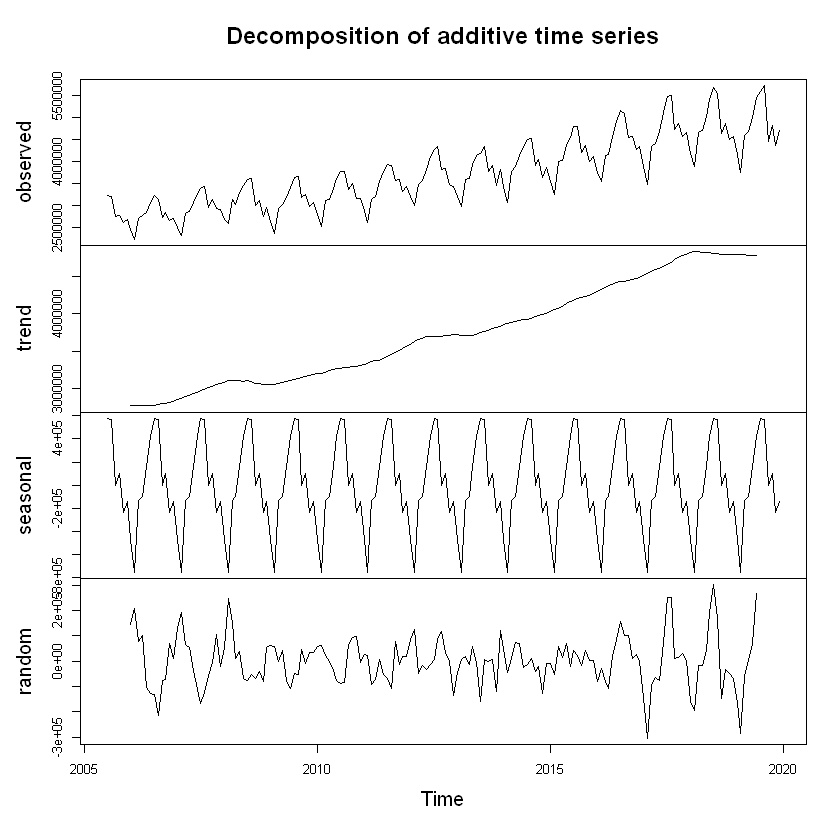

In [57]:
## Checking for Seasonal and trend componenets
plot(decompose(passengers))

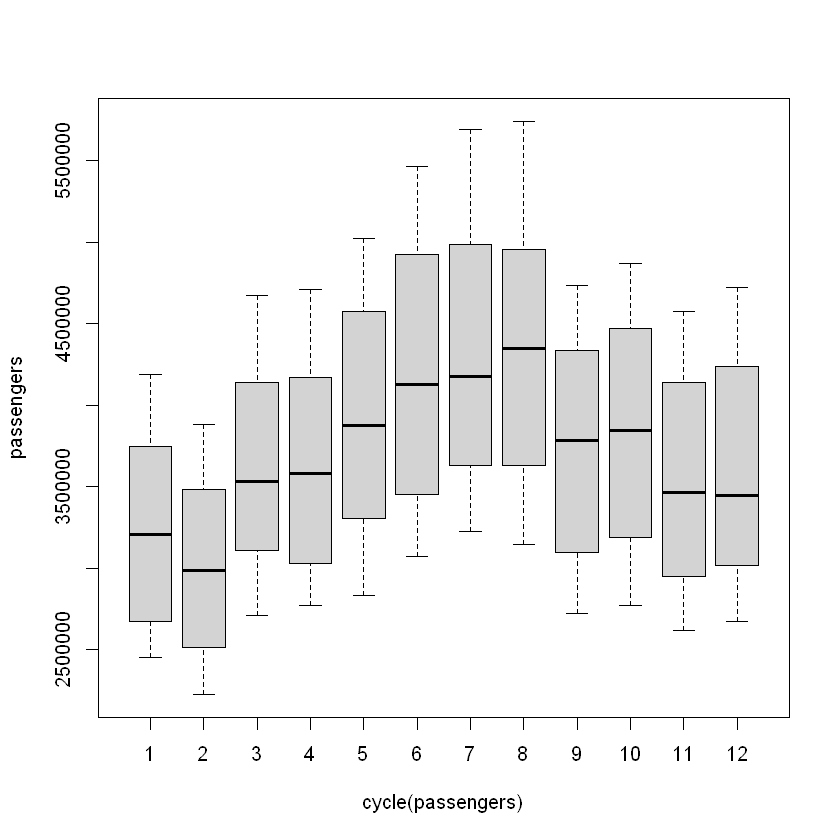

In [58]:
## using the boxplot to see if there is any seasonal effects
boxplot(passengers~cycle(passengers))


## Now, we will check the stationary Status of the primary SFO passenger data

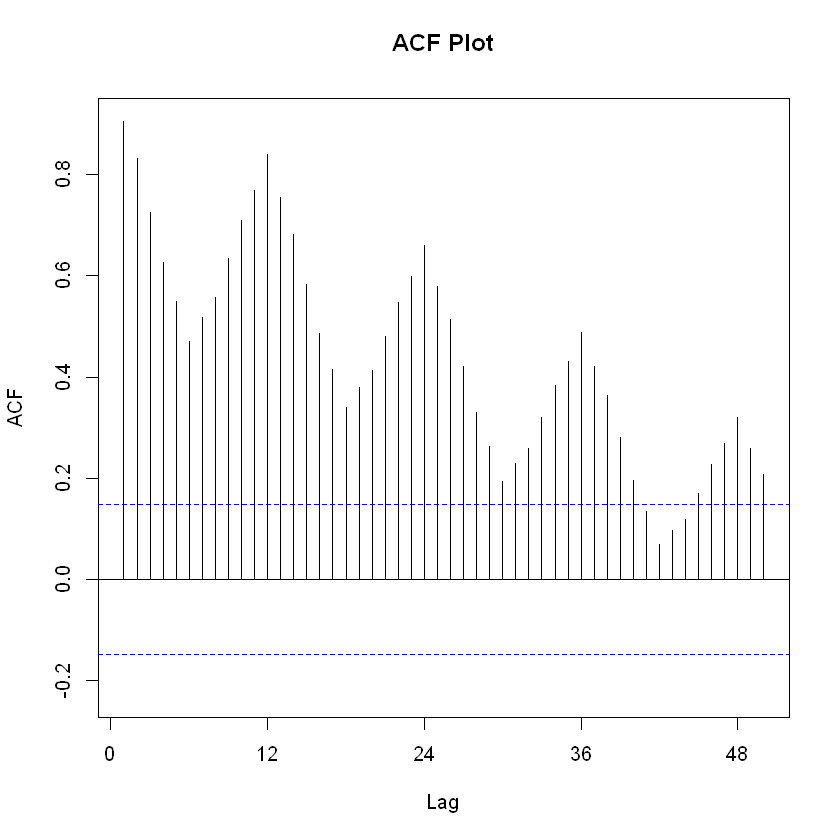

In [59]:
## ACF plot
Acf(passengers, main = "ACF Plot",lag.max = 50)

In [60]:
## Dickey-Fuller Test
adf.test(passengers, alternative ="stationary", k=12)



	Augmented Dickey-Fuller Test

data:  passengers
Dickey-Fuller = -2.0849, Lag order = 12, p-value = 0.5408
alternative hypothesis: stationary


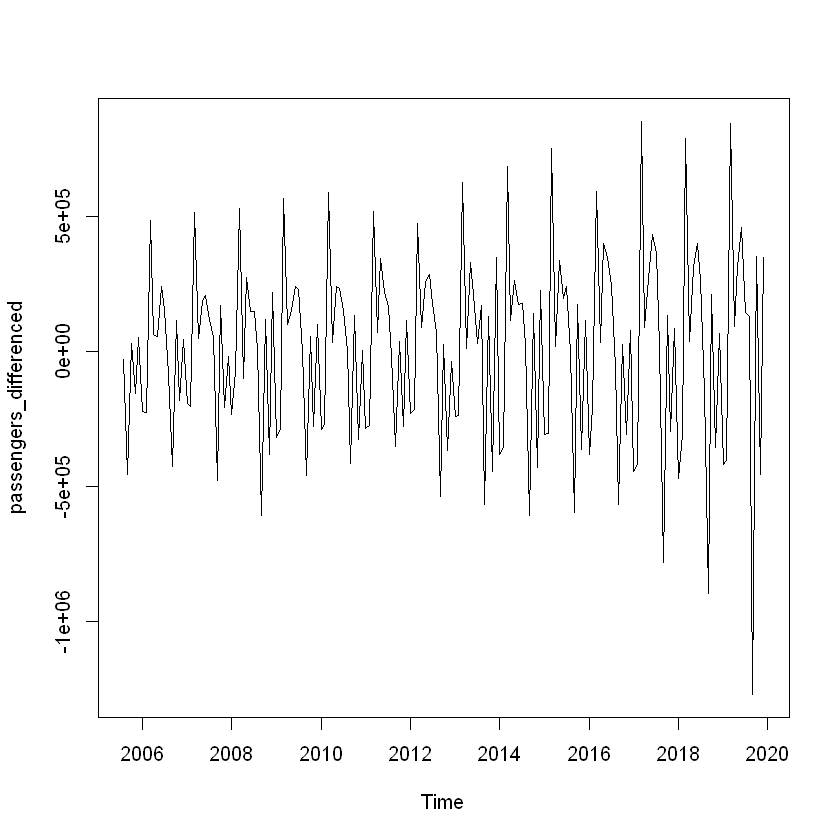

In [64]:
## Plotting the passengers_differenced data
passengers_differenced <- diff(passengers)
plot(passengers_differenced)



	Augmented Dickey-Fuller Test

data:  passengers_differenced
Dickey-Fuller = -3.4519, Lag order = 12, p-value = 0.04893
alternative hypothesis: stationary


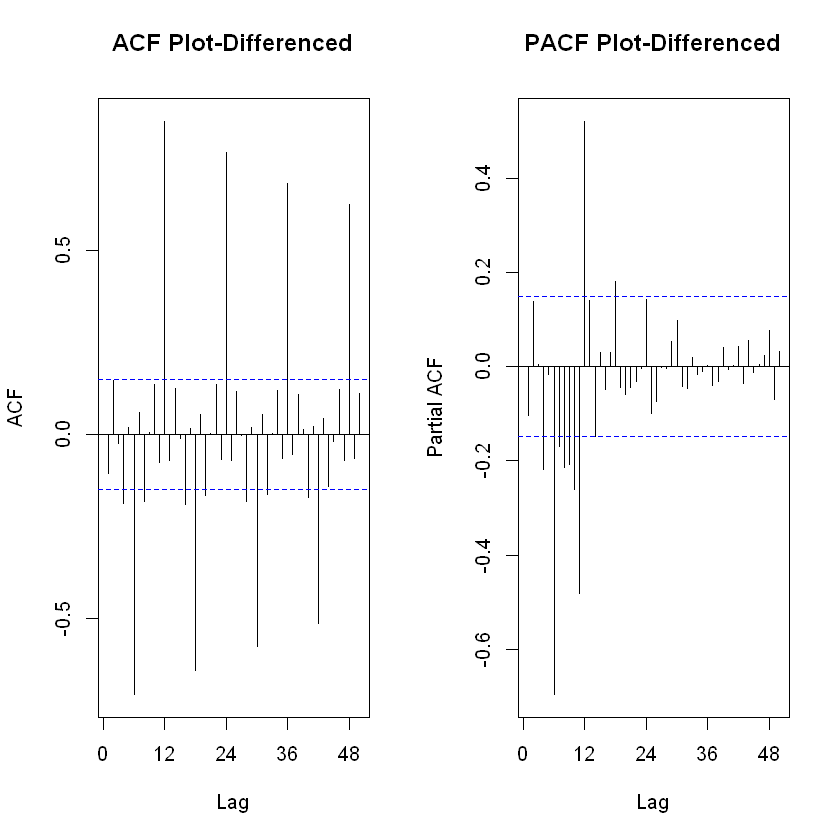

In [63]:
## ACF and PACF and Dickey-Fuller test for differenced data
par(mfrow = c(1,2))
Acf(passengers_differenced, main = "ACF Plot-Differenced",lag.max = 50)
Acf(passengers_differenced, type = "partial", main = "PACF Plot-Differenced",lag.max = 50)
adf.test(passengers_differenced, alternative ="stationary", k=12)

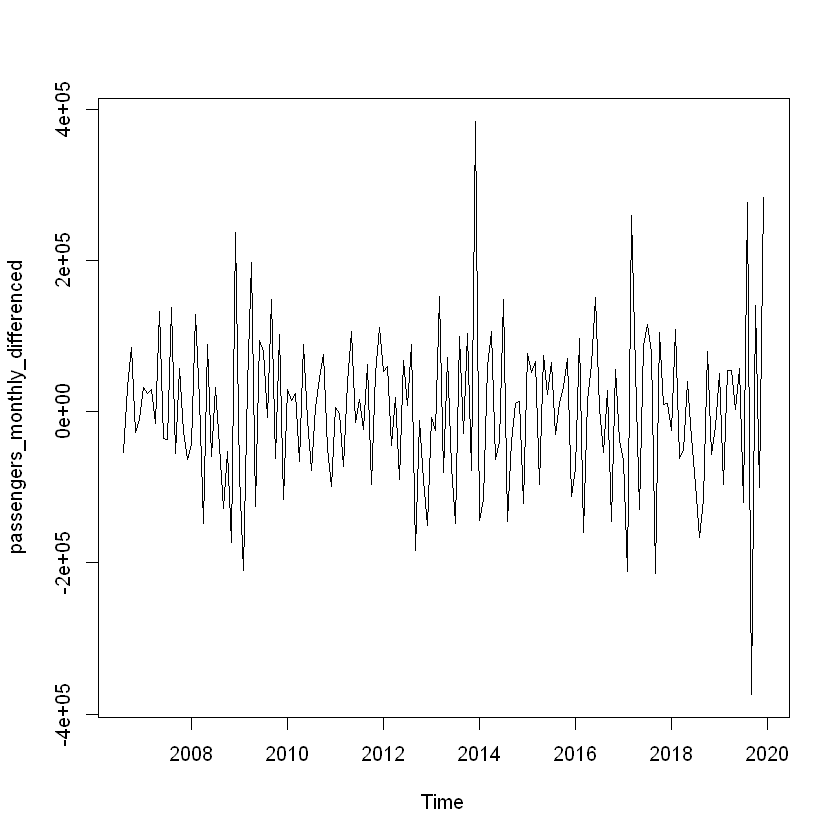

In [65]:
## Plotting the passengers_differenced data with lag12
passengers_monthly_differenced<- diff(passengers_differenced , lag = 12)
plot(passengers_monthly_differenced)


	Augmented Dickey-Fuller Test

data:  passengers_monthly_differenced
Dickey-Fuller = -5.2462, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary


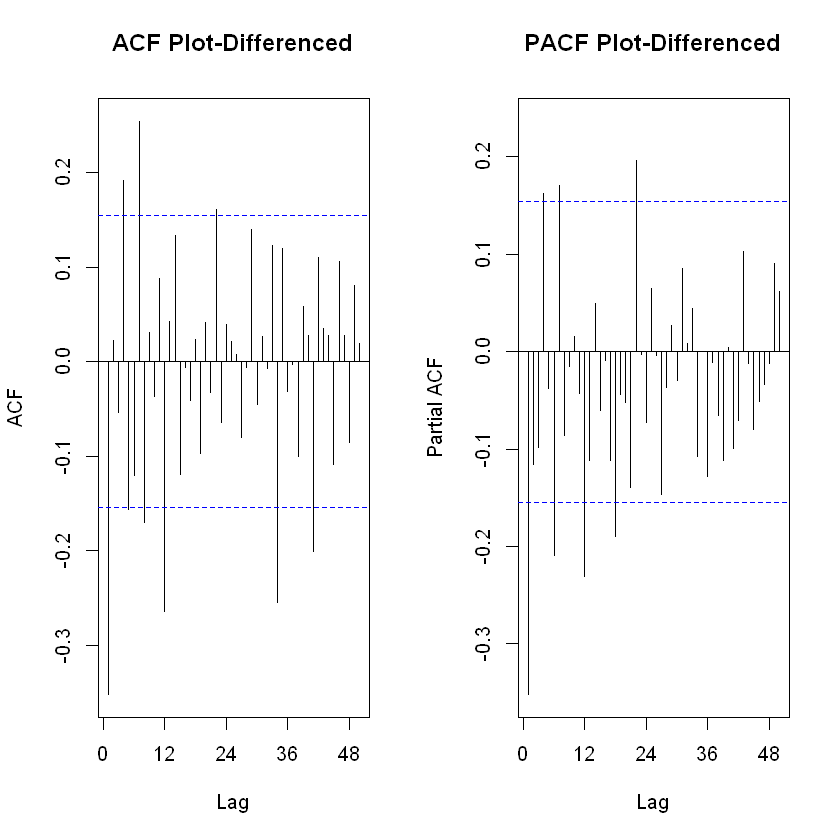

In [66]:
## ACF and PACF for differenced data with lag12
par(mfrow = c(1,2))
Acf(passengers_monthly_differenced, main = "ACF Plot-Differenced",lag.max = 50)
Acf(passengers_monthly_differenced, type = "partial", main = "PACF Plot-Differenced",lag.max = 50)
adf.test(passengers_monthly_differenced, alternative ="stationary", k=12)

# 2. Model Fitting and forecasting

In [68]:
## Dividing dataset into train and test sets
train <- df_precovid[1:150, ]
test <- df_precovid[151:174, ]

## Converting data to Time Series Object
train_ts <- ts(train$passengers, start = c(2005, 7), frequency = 12)
test_ts <- ts(test$passengers, start = c(2018, 1), frequency = 12)


In [69]:
## Fitting Models

### Holt-Winters additive model
fit_hw_additive <- hw(train_ts,seasonal="additive")

### Holt-Winters multiplicative model
fit_hw_multiplicative <- hw(train_ts,seasonal="multiplicative")

### ARIMA model
fit_ARIMA <- auto.arima(train_ts)

Here, we are going to check our models status:


	Ljung-Box test

data:  Residuals from Holt-Winters' additive method
Q* = 54.26, df = 4, p-value = 4.643e-11

Model df: 16.   Total lags used: 20



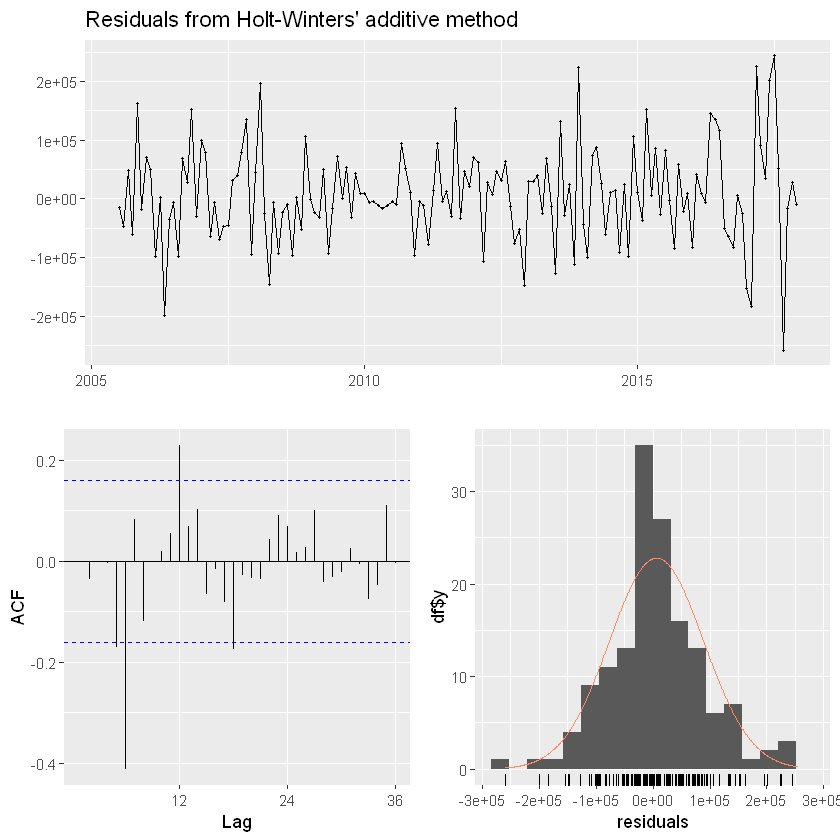

In [70]:
## Holt-Winters additive model with lag 20
checkresiduals(fit_hw_additive, lag = 20)


	Ljung-Box test

data:  Residuals from Holt-Winters' multiplicative method
Q* = 66.97, df = 34, p-value = 0.0006282

Model df: 16.   Total lags used: 50



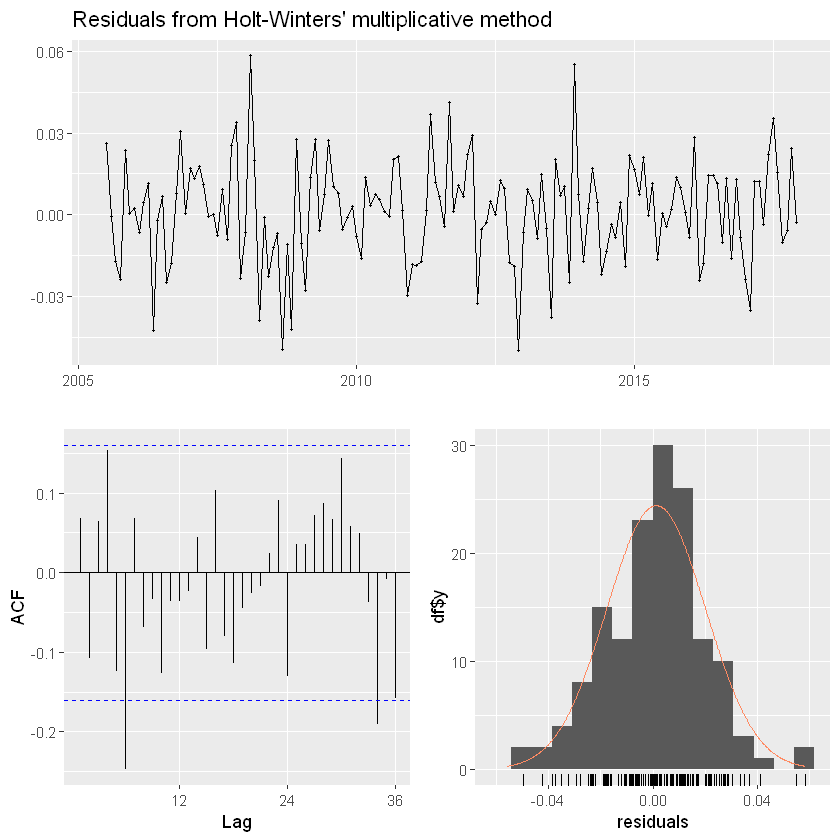

In [74]:
## Holt-Winters multiplicative model with lag 50
checkresiduals(fit_hw_multiplicative, lag = 50)


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(0,1,1)[12]
Q* = 28.071, df = 7, p-value = 0.0002135

Model df: 3.   Total lags used: 10



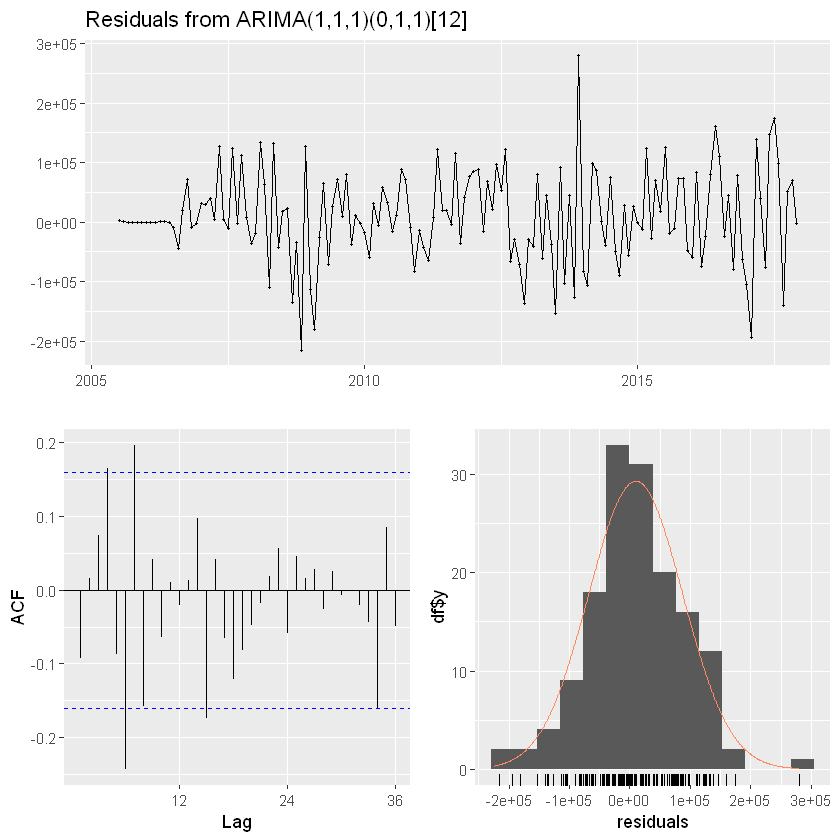

In [76]:
## ARIMA model with lag 10
checkresiduals(fit_ARIMA, lag = 10)

In [78]:
## Coefficient test for ARIMA model
library(lmtest)
coeftest(fit_ARIMA)


z test of coefficients:

      Estimate Std. Error  z value  Pr(>|z|)    
ar1   0.644760   0.102609   6.2837 3.307e-10 ***
ma1  -0.918834   0.062049 -14.8083 < 2.2e-16 ***
sma1 -0.522980   0.085853  -6.0916 1.118e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 0.1046842 0.1592193 0.1362338 0.1480821 0.1604937 0.2167810 0.2362130
 [8] 0.3180006 0.3825076 0.2395645 0.2833488 0.3087641 0.3582081 0.2340877
[15] 0.2394188 0.2973991 0.1854762 0.2188068 0.2694300 0.2813060 0.2085470

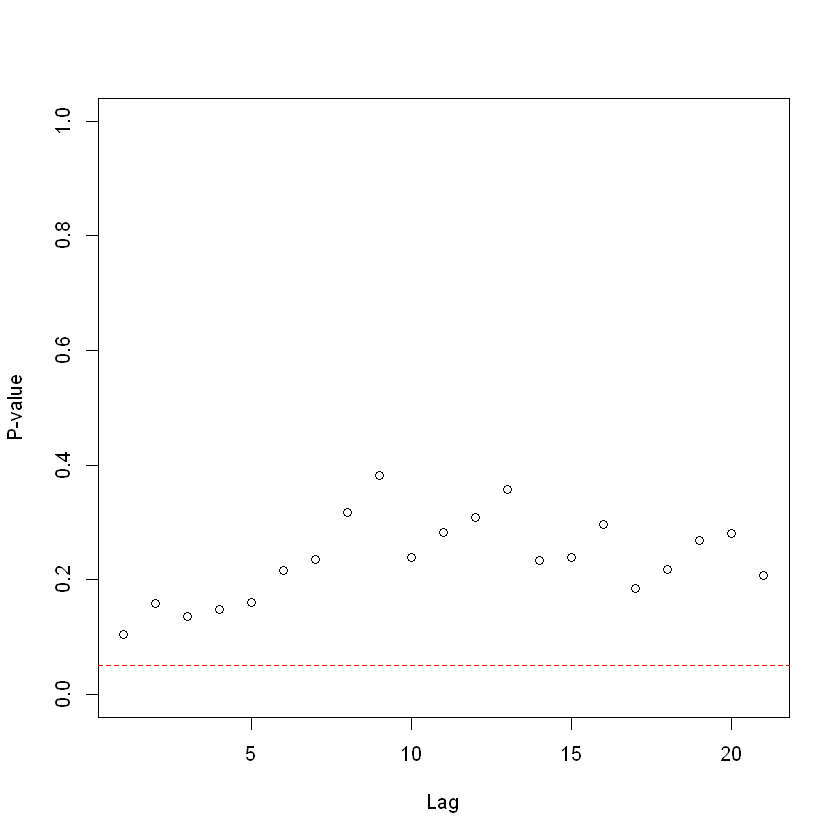

In [79]:
# conditional heteroscedasticity for ARIMA model
library(TSA)
McLeod.Li.test(fit_ARIMA)$p.value

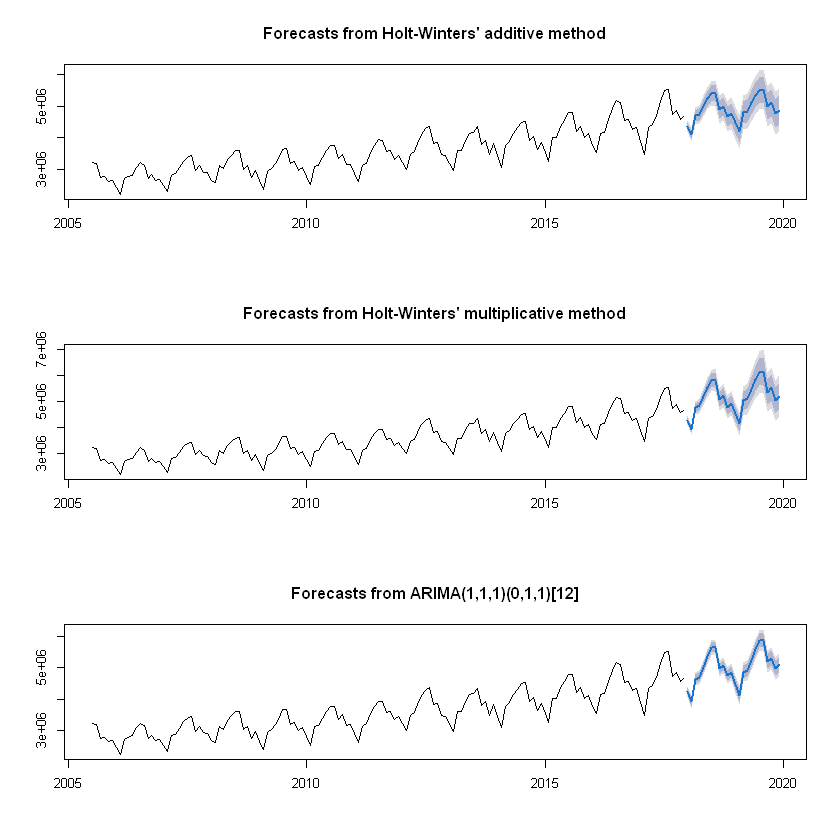

In [83]:
## plotting forcasts for the next 24 month based on the models that we created
par(mfrow = c(3,1))
plot(forecast(fit_hw_additive,h=24))
plot(forecast(fit_hw_multiplicative,h=24))
plot(forecast(fit_ARIMA,h=24))

In [81]:
## Storing forcasted data in suitable variables
pred_hw_additive <- forecast(fit_hw_additive,h=24)
pred_hw_multiplicative <- forecast(fit_hw_multiplicative,h=24)
pred_ARIMA <- forecast(fit_ARIMA,h=24)

# 3. Comparing forcasted data and the real data in the prediction period

## Comparing ARIMA model prediction with actual data

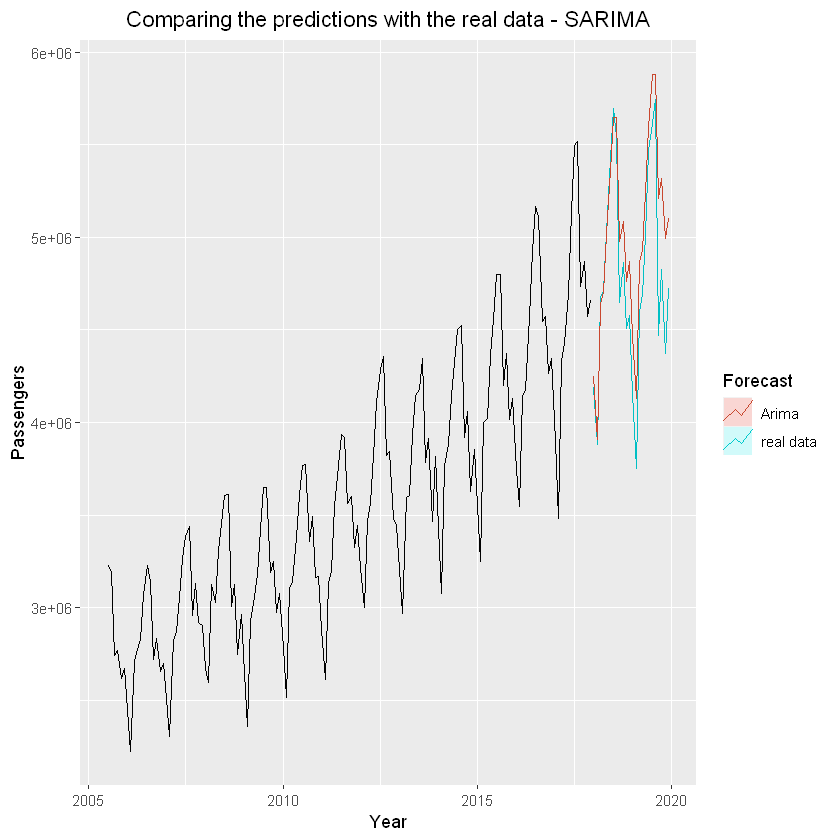

In [84]:
train_ts <- window(train_ts,start=2005)
autoplot(train_ts) +
  autolayer(test_ts, series="real data", PI=FALSE) +
  autolayer(pred_ARIMA, series="Arima", PI=FALSE)+
  xlab("Year") +
  ylab("Passengers") +
  ggtitle("Comparing the predictions with the real data - SARIMA") +
  theme(plot.title = element_text(hjust =0.5))+
  guides(colour=guide_legend(title="Forecast"))

## Comparing Holt-Winters multiplicative model prediction with actual data

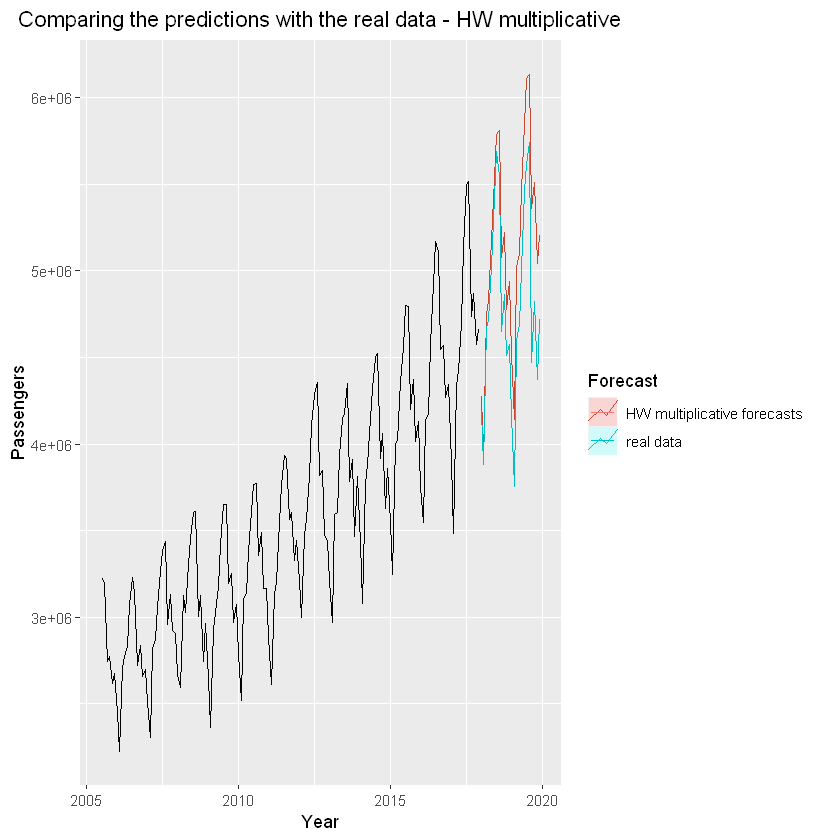

In [33]:
autoplot(train_ts) +
  autolayer(pred_hw_multiplicative, series="HW multiplicative forecasts", PI=FALSE) +
  autolayer(test_ts, series="real data", PI=FALSE) +
  xlab("Year") +
  ylab("Passengers") +
  ggtitle("Comparing the predictions with the real data - HW multiplicative") +
  theme(plot.title = element_text(hjust =0.5))+
  guides(colour=guide_legend(title="Forecast"))

## Comparing Holt-Winters additive model prediction with actual data

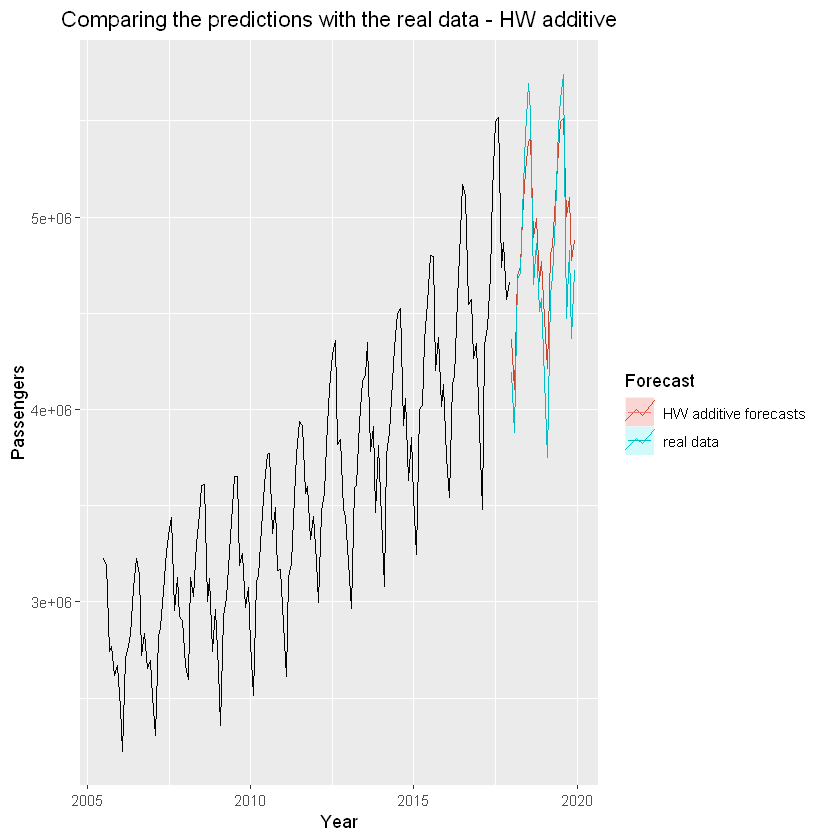

In [87]:
autoplot(train_ts) +
  autolayer(pred_hw_additive, series="HW additive forecasts", PI=FALSE ) +
  autolayer(test_ts, series="real data", PI=FALSE) +
  xlab("Year") +
  ylab("Passengers") +
  ggtitle("Comparing the predictions with the real data - HW additive") +
  theme(plot.title = element_text(hjust =0.5))+
  guides(colour=guide_legend(title="Forecast"))

## Comparing all three models prediction with actual data

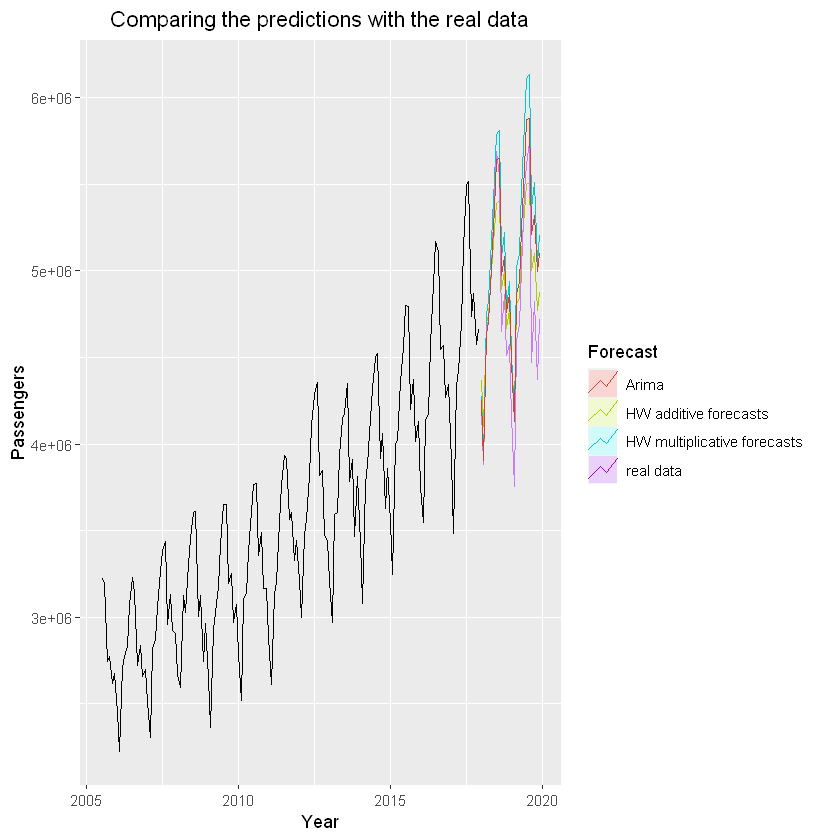

In [35]:
  autolayer(pred_hw_additive, series="HW additive forecasts", PI=FALSE ) +
  autolayer(pred_hw_multiplicative, series="HW multiplicative forecasts", PI=FALSE) +
  autolayer(test_ts, series="real data", PI=FALSE) +
  autolayer(pred_ARIMA, series="Arima", PI=FALSE)+
  xlab("Year") +
  ylab("Passengers") +
  ggtitle("Comparing the predictions with the real data") +
  theme(plot.title = element_text(hjust =0.5))+
  guides(colour=guide_legend(title="Forecast"))

## Caluclating and comparing Error Sum of Squares (SSE) of the models

In [94]:
## Holt-Winters additive model SSE
e_hw_additive= pred_hw_additive$mean - test$passengers
SSE_hw_additive <- sum(e_hw_additive^2)

## Holt-Winters multiplicative model SSE
e_hw_multiplicative= pred_hw_multiplicative$mean - test$passengers
SSE_hw_multiplicative <- sum(e_hw_multiplicative^2)

## ARIMA model SSE
e_ARIMA= pred_ARIMA$mean - test$passengers
SSE_ARIMA <- sum(e_ARIMA^2)

print('Holt-Winters additive model SSE is:')
SSE_hw_additive

print('Holt-Winters multiplicative model SSE is:')
SSE_hw_multiplicative

print('ARIMA model SSE is:')
SSE_ARIMA

[1] "Holt-Winters additive model SSE is:"


[1] 1.376111e+12

[1] "Holt-Winters multiplicative model SSE is:"


[1] 4.00284e+12

[1] "ARIMA model SSE is:"


[1] 2.173271e+12

# 4. One-Step-Ahead forecast

In [96]:
## Spilliting data to train and test subsets for one step forcast for 24 months
train <- df_precovid[1:150, ]
test <- df_precovid[151:174, ]

## Converting the train and test sets to Time-Series-Object
train_ts <- ts(train$passengers, start = c(2005, 7), frequency = 12)
test_ts <- ts(test$passengers, start = c(2018, 1), frequency = 12)

## Holt-Winters Additive Model

In [97]:
## Creating two empty vectors
p <- numeric(length(1:24))
e <- numeric(length(1:24))

## One Step Ahead Forcasting with HW additive model
for(i in 1:24){
  train <- subset(head(df_precovid,174-(25-i)))
  test <- subset(tail(df_precovid,25-i))
  y <- ts(train$passengers, start = c(2005, 7), frequency = 12)
  fit_hw_additive <- hw(y,seasonal="additive")
  pred_hw_additive <- forecast(fit_hw_additive,h=1)
  p[i] <- pred_hw_additive$mean
  e[i] <- p[i]-test$passengers[1]
}

## One Step Ahead Forcast SSE for HW additive model
SSE2_hw_additive <- sum(e^2)

## Comparing forcasted data points with actual data points
test <- subset(tail(df_precovid,24))
comparison_table_hw_additive <- data.frame(test$passengers, p)
colnames(comparison_table_hw_additive) <- c('Actual Data','Prediction')

comparison_table_hw_additive


Actual Data,Prediction
<dbl>,<dbl>
4190367,4365802
3882181,3961629
4674035,4489840
4713183,4682001
5025595,4963097
5427144,5255144
5692572,5564173
5545859,5690269
4649100,5034822


In [98]:
## Creating two empty vectors
p <- numeric(length(1:24))
e <- numeric(length(1:24))

## One Step Ahead Forcasting with HW multiplicative model
for(i in 1:24){
  train <- subset(head(df_precovid,174-(25-i)))
  test <- subset(tail(df_precovid,25-i))
  y <- ts(train$passengers, start = c(2005, 7), frequency = 12)
  fit_hw_multiplicative <- hw(y,seasonal="multiplicative")
  pred_hw_multiplicative <- forecast(fit_hw_multiplicative,h=1)
  p[i] <- pred_hw_multiplicative$mean
  e[i] <- p[i]-test$passengers[1]
}

## One Step Ahead Forcast SSE for HW multiplicative model
SSE2_hw_multiplicative <- sum(e^2)

## Comparing forcasted data points with actual data points
test <- subset(tail(df_precovid,24))
comparison_table_hw_multiplicative <- data.frame(test$passengers, p)
colnames(comparison_table_hw_multiplicative) <- c('Actual Data','Prediction')

comparison_table_hw_multiplicative

Actual Data,Prediction
<dbl>,<dbl>
4190367,4276260
3882181,3879177
4674035,4725783
4713183,4733004
5025595,5112586
5427144,5389374
5692572,5673056
5545859,5724091
4649100,4893695


In [99]:
## Creating two empty vectors
p <- numeric(length(1:24))
e <- numeric(length(1:24))

## One Step Ahead Forcasting with ARIMA model
for(i in 1:24){
  train <- subset(head(df_precovid,174-(25-i)))
  test <- subset(tail(df_precovid,25-i))
  y <- ts(train$passengers, start = c(2005, 7), frequency = 12)
  fit_ARIMA <- auto.arima(y)
  pred_ARIMA <- forecast(fit_ARIMA,h=1)
  p[i] <- pred_ARIMA$mean
  e[i] <- p[i]-test$passengers[1]
}

## One Step Ahead Forcast SSE for ARIMA model
SSE2_ARIMA <- sum(e^2)

## Comparing forcasted data points with actual data points
test <- subset(tail(df_precovid,24))
comparison_table_ARIMA <- data.frame(test$passengers, p)
colnames(comparison_table_ARIMA) <- c('Actual Data','Prediction')

comparison_table_ARIMA

Actual Data,Prediction
<dbl>,<dbl>
4190367,4249069
3882181,3877971
4674035,4635498
4713183,4728467
5025595,5031609
5427144,5390788
5692572,5713695
5545859,5701812
4649100,4917261


Here, we will compare the SSE of One_Step_Ahead forcasting Models:

In [100]:
print('Holt-Winters additive model SSE is:')
SSE2_hw_additive

print('Holt-Winters multiplicative model SSE is:')
SSE2_hw_multiplicative

print('ARIMA model SSE is:')
SSE2_ARIMA

[1] "Holt-Winters additive model SSE is:"


[1] 551210711264

[1] "Holt-Winters multiplicative model SSE is:"


[1] 428795321804

[1] "ARIMA model SSE is:"


[1] 398901899628

# 5. Prediction for after covid to see the covid effect on the passengers number

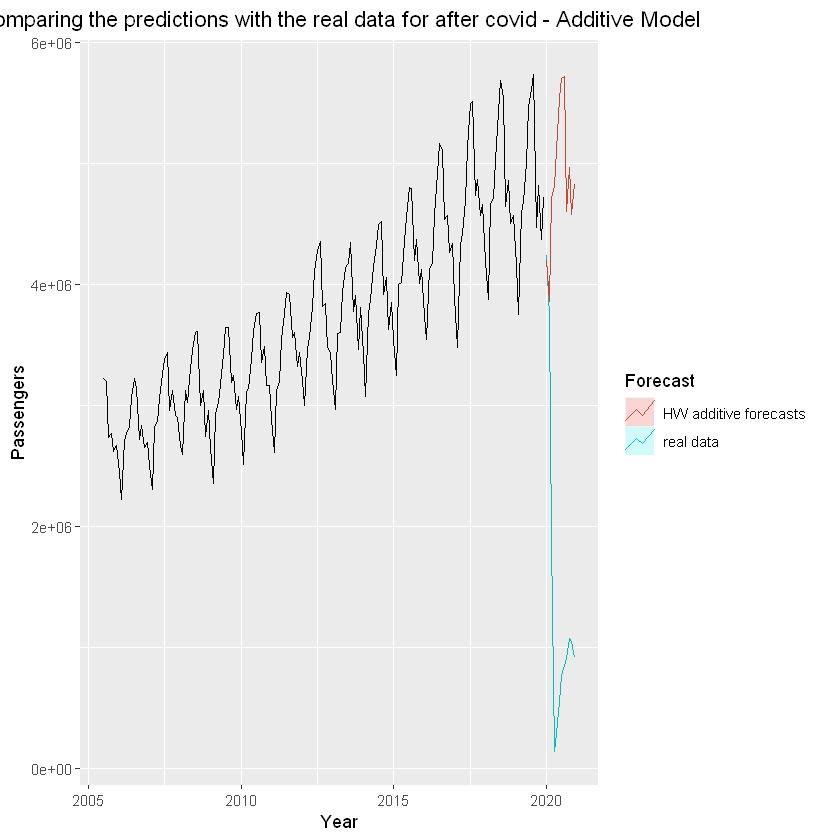

In [46]:
## Storing pre-covid and after-covid data to suitable variables
df_precovid <- subset(df, Date<'2020-01-01')
df_aftercovid  <- subset(df, Date >= '2020-01-01')

## Converting pre-covid and after-covid data to Time Series Objects
df_precovid <- ts(df_precovid$passengers, start = c(2005, 7), frequency = 12)
df_aftercovid <- ts(df_aftercovid$passengers, start = c(2020, 1), frequency = 12)

## Fitting Holt-Winters Additive Model
fit_hw_additive <- hw(df_precovid,seasonal="additive")
pred_hw_additive <- forecast(fit_hw_additive,h=12)

## Comparing actualafter-covid data with the prediction based on pre-covid data
df_precovid <- window(df_precovid,start=2005)
autoplot(df_precovid) +
  autolayer(df_aftercovid, series="real data", PI=FALSE) +
  autolayer(pred_hw_additive, series="HW additive forecasts", PI=FALSE )+
  xlab("Year") +
  ylab("Passengers") +
  ggtitle("Comparing the predictions with the real data for after covid - Additive Model") +
  theme(plot.title = element_text(hjust =0.5))+
  guides(colour=guide_legend(title="Forecast"))

